In [44]:
import pyqsp.angle_sequence
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from IPython.utils import io
from functools import reduce
from scipy.linalg import sqrtm, expm

PAULI_X = np.array([[0, 1], [1, 0]])
PAULI_Z = np.array([[1, 0], [0, -1]])
HADAMARD = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

# Quantum Singular Value Transformation (QSVT)
This notebook is primarily based on the paper "Grand Unification of Quantum Algorithms" [1], which I also recommended for further details. As of today, there are three key quantum algorithms: search, factoring, and simulation. Although they seemingly don't have much in common, all of them can be unified as instances of the **quantum singular value transformation algorithm**. So, how do you construct an algorithm using QSVT? Here are the four main steps you need to take [2]:
1. Create a function $f(x)$ representing your problem, which is applied to the singular values of a matrix $A \mapsto f(A)$
2. Block-encode your matrix $A$ into a unitary $U$ $$U = \begin{bmatrix} A & \cdot \\ \cdot & \cdot \end{bmatrix} $$
3. Find a polynomial approximation $p(x)$ for your function $f(x)$
4. Construct a circuit $U_{\vec{\phi}}$ that applies $p(A)$ to $A$ $$U_{\vec{\phi}} = \begin{bmatrix} p(A) & \cdot \\ \cdot & \cdot \end{bmatrix} $$
Don't worry if this doesn't immediately make sense, we'll go through each step except constructing polynomial approximations, and then proceed with two examples: Grover's search and Hamiltonian Simulation. As QSVT essentially provides a framework for transforming matrices that are embedded in larger unitary matrices, let us begin with the simplest case of applying a polynomial to a scalar $a$ encoded inside a 2x2 matrix, a process known as Quantum Signal Processing.

## Quantum Signal Processing (QSP)
With QSP you want to polynomial transform a Signal $a$. This is achieved by interleaving two different kinds of single-qubit rotations. For this we need two operators.
The first one is the **signal rotation operator W**, which encodes the signal $a$ into a matrix and performs an x-rotation by angle $\theta = -2 cos ^ {-1} a$ through the Bloch Sphere.
For a fixed value $a \in [-1, 1]$, the operator is defined as:
$$ W(a) = \begin{bmatrix}
a & i \sqrt{1 - a ^ 2} \\
i \sqrt{1 - a ^ 2} & a
\end{bmatrix} $$

In [45]:
def W(a):
    """Returns the signal-rotation operator for a value a."""
    return np.array([[a, 1j * np.sqrt(1 - np.square(a))], [1j * np.sqrt(1 - np.square(a)), a]])

The second operator we need is the **signal-processing rotation operator S**, which is  defined as:
$$ S(\phi) = e ^ {i \phi Z} = \begin{bmatrix}
e ^ {i\phi} & 0 \\
0 & e ^ {-i\phi}
\end{bmatrix} $$
and does a z-rotation by angle $-2 \phi$.

In [46]:
def S(phi):
    """Returns the signal-processing rotation operator for an angel phi."""
    return np.array([[np.exp(1j * phi), 0], [0, np.exp(1j * -phi)]])

By alternating these two, we get the QSP operation sequence $U_{\vec{\phi}}$:
$$ U_{\vec{\phi}}(a) = e ^ {i \phi Z} \prod ^ d_{k = 1} W(a) e ^ {i \phi Z} = \begin{bmatrix} P(a) & i Q a \sqrt{1 - a ^2} \\ i Q ^ * a \sqrt{1 - a ^2} & P ^ * (a)\end{bmatrix} $$
As you can see, this results in a polynomial transformation of $a$ in the upper left corner of the matrix. The other entries aren't really that relevant to us. The following theorem describes the polynomials we can obtain using this method.

**Theorem** (Quantum Signal Processing): The QSP sequence $U_{\vec{\phi}}$ produces a matrix which may be expressed as a polynomial function of a: $$ U_{\vec{\phi}}(a) = \begin{bmatrix} P(a) & i Q a \sqrt{1 - a ^2} \\ i Q ^ * a \sqrt{1 - a ^2} & P ^ * (a)\end{bmatrix} $$ for $a \in [-1, 1]$, and a $\vec{\phi} = (\phi_0, ..., \phi_d) \in \mathbb{R} ^ {d + 1}$ exist for any polynomial $P(a), Q(a)$ in $a$ such that:
    1. $deg(P) \le d$ and $deg(Q) \le d - 1$
    2. $P$ has parity $d\mod 2$ and $Q$ has parity $d - 1\mod 2$
    3. $|P| ^ 2 + (1 - a ^ 2) |Q| ^ 2 = 1$


The truly important aspect of QSP is that the inverse statement also holds. Given a polynomial $P$ that satisfies the conditions mentioned above, we can efficiently compute the phase angles needed to realize it [3].  In this notebook, we won't delve into the specifics of finding these angles and will instead rely on the [pyqsp](https://github.com/ichuang/pyqsp) library to compute them.

In [47]:
def QSP(phi_vec, a):
    """Returns the matrix resulting from computing the QSP operation sequence for the signal a and phase angles phi_vec."""
    w = W(a)
    res = S(phi_vec[0])
    for i in range(1, len(phi_vec)):
        res = res @ w @ S(phi_vec[i])
    return res

There are different options for choosing the signal rotation and signal rotation processing operators, but all are equally powerful. For the signal rotation operator, we use the W-convention. Another commonly used one is the R-convention, which defines the signal rotation operator as follows:
$$ R(a) = \begin{bmatrix}
a & \sqrt{1 - a ^ 2} \\
\sqrt{1 - a ^ 2} & -a
\end{bmatrix} $$
The equivalence follows from $R(a) = -ie ^ {i \frac \pi 4 Z} \cdot W(a) \cdot ie ^ {i \frac \pi 4 Z}$.

In [48]:
def angles_from_W_to_R(phi_vec):
    """Returns phase angles for the W-convention in the R-convention."""
    return [phi_vec[0] + (2 * (len(phi_vec) - 1) - 1) * np.pi / 4] \
           + [phi - np.pi / 2 for phi in phi_vec[1:-1]] \
           + [phi_vec[-1] - np.pi / 4]

### Chebyshev polynomial with QSP
When parametrizing the QSP sequence with the phase angles $\vec{\phi} = (0, ..., 0) \in \mathbb{R} ^ {N + 1}$, we get the Chebyshev polynomial of the first kind $T_N$.

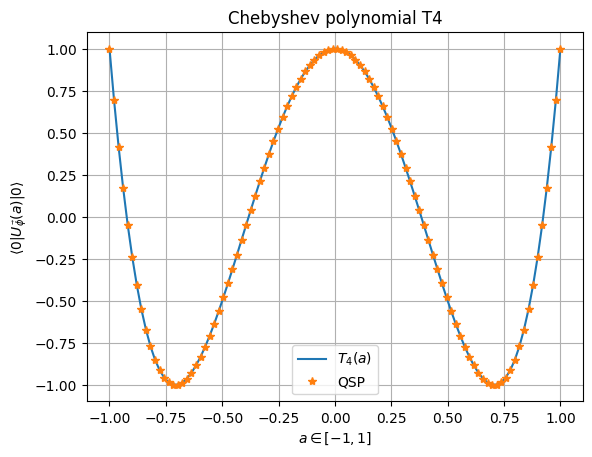

In [49]:
T_4 = np.polynomial.Polynomial([1., 0., -8., 0., 8.])
phi_vec_T_4 = [0] * 5
a_vec = np.linspace(-1, 1, 100)
T_4_qsp = [QSP(phi_vec_T_4, a)[0, 0].real for a in a_vec]

plt.plot(a_vec, T_4(a_vec), label="$T_{4}(a)$")
plt.plot(a_vec, T_4_qsp, '*', label="QSP")
plt.title("Chebyshev polynomial T4")
plt.xlabel(r"$a \in [-1, 1]$")
plt.ylabel(r"$\langle 0 \vert U_{\vec{\phi}}(a) \vert 0 \rangle$")
plt.legend(loc='best')
plt.grid(True)

plt.show()

### BB1 pulse sequence
The BB1 pulse sequence originates from the field of magnetic resonance imaging, where it is employed to enhance picture contrast. The phase angles are defined as $\vec{\phi} = (\frac \pi 2, -\eta, 2\eta, 0, -2\eta, \eta)$, with $\eta = \frac 1 2 cos ^ {-1} (- \frac 1 4)$. When plotting the probability of a $|0\rangle$ qubit input remaining unchanged under this operation against the probability of the same qubit remaining unchanged with $\vec{\phi} = (0, 0)$, i.e. no processing, we can observe that the qubit remains unflipped over a broader range of signal angles.

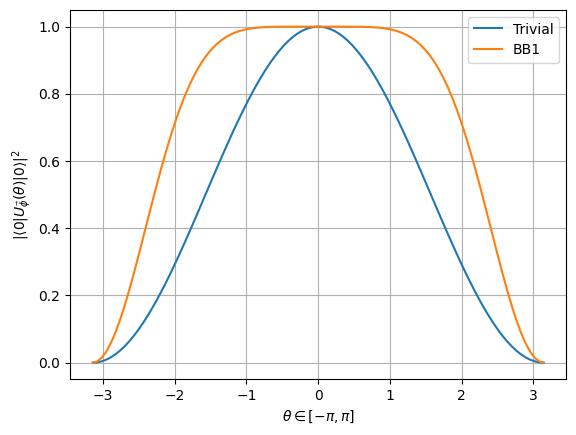

In [50]:
theta_vec = np.linspace(-np.pi, np.pi, 100)
a_vec = [np.cos(-0.5 * theta) for theta in theta_vec]

phi_trivial_vec = [0, 0]
p_trivial_vec = [np.square(np.abs(np.array([1, 0]) @ QSP(phi_trivial_vec, a) @ np.array([1, 0]))) for a in a_vec]

eta = 0.5 * np.arccos(-0.25)
phi_bb1_vec = [np.pi / 2, -eta, 2 * eta, 0, -2 * eta, eta]
p_bb1_vec = [np.square(np.abs(np.array([1, 0]) @ QSP(phi_bb1_vec, a) @ np.array([1, 0]))) for a in a_vec]

plt.plot(theta_vec, p_trivial_vec, label="Trivial")
plt.plot(theta_vec, p_bb1_vec, label="BB1")
plt.xlabel(r"$\theta \in [-\pi, \pi]$")
plt.ylabel(r"$\vert \langle 0 \vert U_{\vec{\phi}}(\theta) \vert 0 \rangle \vert^2$")
plt.legend(loc='best')
plt.grid(True)

plt.legend()
plt.show()

## Quantum Eigenvalue Transformation (QEVT)
In the last section, we polynomially transformed a one-dimensional matrix element. Now, we want to expand this to an entire vector space. Before finally arriving at QSVT, we will take one more intermediate step: instead of using any matrix $A$ we will consider a Hamiltonian $\mathcal{H} = \sum_\lambda \lambda \vert \lambda \rangle \langle \lambda \vert$ and transform all its eigenvalues $\lambda$, hence the name Quantum Eigenvalue Transformation. Two new concepts we need for this are block-encoding and the projector-controlled phase shift operation.
### Block-encoding
Since a hermitian matrix $\mathcal{H}$ is generally not unitary, we need to encode $\mathcal{H}$ into a larger unitary matrix $U$. $$U = \begin{bmatrix} \mathcal{H} & \cdot \\ \cdot & \cdot \end{bmatrix} $$
Finding a specific block-encoding for an arbitrary matrix $A$ is not a trivial task. However, if $A$ is square, as is the case for Hamiltonians, we can use this specific block-encoding: $$U = \begin{bmatrix} A & \sqrt{I - A ^ 2} \\ \sqrt{I - A ^ 2} & -A \end{bmatrix} $$ Do you see the similarity to the signal rotation operator in the R-convention? Another restriction of this encoding is that $\vert\vert A \vert\vert \leq$ 1. In practice, this isn't a significant issue because if $A$ does not fulfill this restriction, we can simply divide it by a scalar so that it does.
A side note at this point: this notebook only works with square matrices whose spectral norm is less than or equal to 1. This restriction also applies to QSVT later on, as otherwise we would need a significantly more complex block encoding method.

In [51]:
def block_encode_square_matrix(A):
    """Returns the square Matrix A, whose spectral norm is <= 1, block encoded into a unitary matrix."""
    U = np.kron(PAULI_Z, A) + np.kron(PAULI_X, sqrtm(np.eye(A.shape[0]) - A @ A))
    assert np.allclose(U @ U.conj().T, np.eye(2 * len(A)), atol=1e-5), "For this block-encoding to work, A must be square and its spectral norm must be <= 1."
    return U

To locate $\mathcal{H}$ in $U$ we use a projector $\Pi := \vert 0 \rangle \langle 0 \vert$, such that $$\mathcal{H} = \Pi U \Pi$$

In [52]:
def projector_from_state(state):
    """Returns the projector matrix form a given quatum state vector."""
    return np.outer(state, state.conj())

### Projector-controlled phase shift
In analogy to QSP, we just generalized the $W(a)$ operator. Now we need to generalize the corresponding $S(\phi)$ as well. We do this with the projector-controlled phase shift operation $\Pi_\phi := e^{i 2 \phi \Pi} = e^{i \phi (2\Pi - I)}$. This imparts a phase $e^{i 2 \phi}$ on the subspace determined by the projector $\Pi$. This operator can be realized by employing two instances of projector-controlled-NOT gates around an ancilla qubit on which we perform a z-rotation by angle $\phi$.

![](./images/cpnot.png)


In [53]:
def projector_rotation(P, phi):
    """Returns the projector-controlled phase shift operator for the projector P and angle phi."""
    return expm(complex(0, phi) * (2 * P - np.eye(len(P))))

### QEVT
Putting it all together our QEVT operation sequence $U_{\vec{\phi}}$ for polynomially transforming all the eigenvalues $\lambda$ of $\mathcal{H}$ becomes:
$$U_{\vec{\phi}} = \Pi_{\phi_0} \prod ^ d _{k = 1} U \Pi_{\phi_k} = \begin{bmatrix} Poly(\mathcal{H}) & \cdot \\ \cdot & \cdot \end{bmatrix}$$ where $Poly(\mathcal{H}) = \sum_\lambda Poly(\lambda) \vert \lambda \rangle \langle \lambda \vert$.

In [54]:
def QEVT(U, phi_vec):
    """Returns the matrix resulting from computing the QEVT operation sequence for the unitary U and phase angles phi_vec."""
    P = np.kron(np.array([[1, 0], [0, 0]]), np.eye(len(U) // 2))

    res = projector_rotation(P, phi_vec[0])
    for i in range(1, len(phi_vec)):
        res = res @ U @ projector_rotation(P, phi_vec[i])

    return res

### Hamiltonian Simulation [2]
An obvious application for QEVT is Hamiltonian simulation. The goal here is to approximate the time evolution operator $e^{i\mathcal{H}t}$. To achieve this, we need to determine how to apply the function $f(x) = e^{ixt}$. The challenge is that  $f$ does not possess the required odd or even parity as stipulated by the QSP theorem. However, we can express $e^{ixt}$ as $cos(xt) - isin(xt)$, with $cos$ having even parity and $sin$ having odd parity. Therefore, we calculate each function separately and then combine them afterwards using the following circuit:

![](./images/Hamiltonian_simulation.png)

To approximate $sin$ and $cos$ at a specified $t$ we use the Jacobi-Anger expansion. We truncate this series expansion at some index $k$, which is determined by the desired $\epsilon$-accuracy and $t$. This leaves us with the degree, i.e. algorithm, scaling as $\mathcal{O}(\alpha \vert t \vert + \frac {log(1 / \epsilon)} {log(e + \frac {log(1 / \epsilon)} {\alpha t})})$, with $\alpha = \vert \vert \mathcal{H} \vert \vert$.

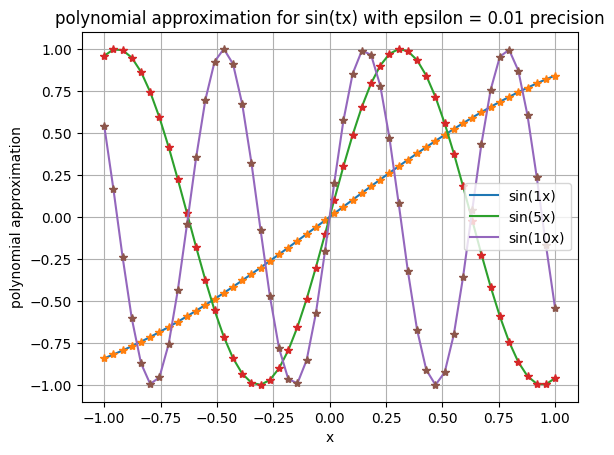

In [55]:
def sin_approximating_polynomial(t, epsilon):
    """Returns the polynomial that approximates sin(xt) with epsilon accuracy."""
    sin = pyqsp.poly.PolySineTX()
    return np.polynomial.Polynomial(sin.generate(tau=t, epsilon=epsilon, ensure_bounded=True))


def cos_approximating_polynomial(t, epsilon):
    """Returns the polynomial that approximates cos(xt) with epsilon accuracy."""
    cos = pyqsp.poly.PolyCosineTX()
    return np.polynomial.Polynomial(cos.generate(tau=t, epsilon=epsilon, ensure_bounded=True))


x = np.linspace(-1, 1, 50)

for t in [1, 5, 10]:
    plt.plot(x, np.sin(t * x), label=f'sin({t}x)')
    with io.capture_output() as captured:
        p = sin_approximating_polynomial(t, 0.01)
        plt.plot(x, 2 * p(x), '*')

plt.title("polynomial approximation for sin(tx) with epsilon = 0.01 precision")
plt.xlabel('x')
plt.ylabel('polynomial approximation')
plt.legend(loc='best')
plt.grid(True)

plt.legend();

Now that we have polynomials that accurately approximate our desired functions, we will implement QEVT for Hamiltonian simulation. We will examine how this algorithm scales with time and analyze the behavior of the error.

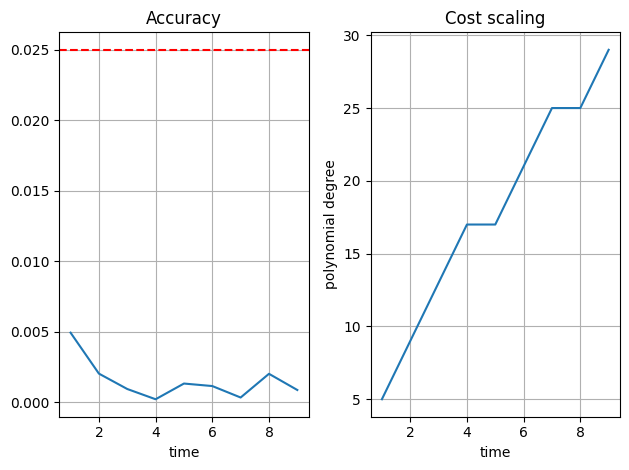

In [56]:
np.random.seed(1)

num_qubits = 1
N = 2 ** num_qubits

#construct a random Hamiltonian that is positive definite and whose spectral norm is <= 1
V = scipy.stats.unitary_group.rvs(N, random_state=1)
D = np.random.uniform(low=0, high=1, size=(N,))
D_matrix = np.diag(D)
H = V @ D_matrix @ V.conj().T

#construct a unitary from H
U = block_encode_square_matrix(H)

t_vec = np.arange(1, 10)

accuracies = []
degrees = []
epsilon = 0.025

for t in t_vec:
    #approximate cos, compute QEVT phases and the QEVT sequence itself
    with io.capture_output() as captured:
        p_cos = cos_approximating_polynomial(t, epsilon)
        phi_cos_vec = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p_cos.coef, signal_operator='Wx')
    phi_cos_vec = angles_from_W_to_R(phi_cos_vec)
    U_cos = QEVT(U, phi_cos_vec)

    #approximate sin, compute QEVT phases and the QEVT sequence itself
    with io.capture_output() as captured:
        p_sin = sin_approximating_polynomial(t, epsilon)
        phi_sin_vec = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p_sin.coef, signal_operator='Wx')
    phi_sin_vec = angles_from_W_to_R(phi_sin_vec)
    U_sin = QEVT(U, phi_sin_vec)

    #keep track of the polynomial degree for a given t
    degrees.append(len(phi_sin_vec) + len(phi_cos_vec) - 2)

    #extract the transformed Hamiltoninans for sin and cos terms
    H_cos = U_cos[:N, :N] + U_cos[:N, :N].conj().T
    H_sin = U_sin[:N, :N] + U_sin[:N, :N].conj().T

    #combine the cos and sin part into an exponential
    H_transformed = H_cos - 1j * H_sin

    #computing the accuracy of the QEVT by subtracting the exact evolution
    accuracy = np.linalg.norm(H_transformed - scipy.linalg.expm(-1j * H * t), ord=2)
    accuracies.append(accuracy)

#plot accuracy vs. time
plt.subplot(1, 2, 1)
plt.plot(t_vec, accuracies)
plt.axhline(epsilon, color='red', linestyle='--')
plt.xlabel('time')
plt.title('Accuracy')
plt.grid(True)

#plot degree vs. time
plt.subplot(1, 2, 2)
plt.plot(t_vec, degrees)
plt.xlabel('time')
plt.ylabel('polynomial degree')
plt.title('Cost scaling')
plt.grid(True)

plt.tight_layout()

## Quantum Singular Value Transformation (QSVT)
Finally, we arrive at QSVT. The major difference from QEVT is that we now allow any matrix to be polynomially transformed, regardless of its dimensions. This means that we can no longer use the eigenvalues $\lambda$ for transformation, as not every matrix has them. Instead, we use the singular values $\sigma$ because every matrix can be decomposed as $A = W \Sigma V^\dagger$, with $W$ and $V$ being the left and right singular vector spaces, and  $\Sigma$ being a diagonal matrix of singular values. We again encode $A$ into an unitary $U$: $$U = \begin{bmatrix} A & \cdot \\ \cdot & \cdot \end{bmatrix} $$
To access $A$, we now need two different projectors, $\Pi$ and $\overset{\sim}{\Pi}$, because the left and right singular space are usually not equal. $A$ is then $\Pi U \overset{\sim}{\Pi}$.
Our QSVT operation sequence $U_{\vec{\phi}}$ also becomes more complicated because we need to distinguish between even and odd polynomials. The sequence for odd degree $d$ polynomials starts in the right singular vector space and ends in the left singular vector space, whereas the even $d$ sequence starts and ends in the right singular vector space.
$$U_{\vec{\phi}} = \begin{cases} \Bigg[ \prod ^ {d / 2}_{k = 1} \Pi_{\phi_{2k - 1}} U(A)^\dagger \overset{\sim}{\Pi}_{\phi_{2k}} U(A) \Bigg] \Pi_{\phi_{d + 1}} & & \text{for d even} \\ \overset{\sim}{\Pi}_{\phi_{1}} \Bigg[ \prod ^ {(d - 1) / 2}_{k = 1} \Pi_{\phi_{2k}} U(A)^\dagger \overset{\sim}{\Pi}_{\phi_{2k + 1}} U(A) \Bigg] \Pi_{\phi_{d + 1}} & & \text{for d odd} \end{cases} = \begin{bmatrix} Poly(A) & \cdot \\ \cdot & \cdot \end{bmatrix}$$
Here, $Poly(A)$ is defined as $\sum_k Poly(\sigma_k) \vert w_k \rangle \langle v_k \vert$ for an odd polynomial and $\sum_k Poly(\sigma_k) \vert v_k \rangle \langle v_k \vert$ for an even one. With QEVT these two cases simplified to one because, for a Hamiltonian, $U$ and $U^\dagger$ are the same.

For simplicity reasons, the following code still only uses square matrices as mentioned above, even though QSVT works for all dimensions of matrices.

In [57]:
def QSVT(U, PL, PR, phi_vec):
    """Returns the matrix resulting from computing the QEVT operation sequence for the unitary U, the left and right projector PL, PR and phase angles phi_vec."""
    conjugate_transpose_U = U.conj().T
    res = np.eye(len(U))

    #for odd polynomials the number of angles is even
    if len(phi_vec) % 2 == 0:
        res = projector_rotation(PL, phi_vec[0]) @ U
        for i in range(1, len(phi_vec) - 1, 2):
            res = res @ projector_rotation(PR, phi_vec[i]) @ conjugate_transpose_U @ projector_rotation(PL, phi_vec[
                i + 1]) @ U
    else:
        for i in range(0, len(phi_vec) - 1, 2):
            res = res @ projector_rotation(PR, phi_vec[i]) @ conjugate_transpose_U @ projector_rotation(PL, phi_vec[
                i + 1]) @ U

    return res @ projector_rotation(PR, phi_vec[-1])

### Grover's Search [2]
Another widely spread problem that benefits from quantum speed up is unstructured search. Given an unstructured database of $N$ elements, the goal is to find a single marked element $m \in \{0, ..., N-1\}$. With a classical computer this problem would be solved in $\mathcal{O}(N)$ time, but with Grover's quantum search algorithm, it only takes $\mathcal{O}(\sqrt N)$ time.
We are given access to an oracle $U$, which performs a phase flip on the marked state: $m$: $$U \vert j \rangle = \begin{cases}
    -\vert j \rangle & & \vert j \rangle = \vert m \rangle \\
    \vert j \rangle & & \vert j \rangle \neq \vert m \rangle
\end{cases} $$
For our initial state, we take the uniform superposition over all $N$ states:
$$\vert \psi_0 \rangle = \frac 1 \sqrt N \sum ^ N_j \vert j \rangle = \sqrt{\frac {N - 1} N} \vert m ^ \perp \rangle + \frac 1 \sqrt N \vert m \rangle$$
Our goal now is to map $\vert \psi_0 \rangle$ to $\vert m \rangle$. As seen above, $\vert \psi_0 \rangle$ has a nonzero projection on the final state $\vert m \rangle$. Using $\Pi := \vert m \rangle \langle m \vert$, this condition is equivalent to: $$\Pi V \vert \psi_0 \rangle = a \vert m \rangle$$
with $V$ as the identity and $a = \frac 1 \sqrt N$. For general amplitude amplification problems, $V$ doesn't need to be trivial, as it's later the case with our implementation. With $\Pi'$ as $\vert \psi_0 \rangle \langle \psi_0 \vert$, this equation becomes: $$ \Pi V \Pi' = a \vert m \rangle \langle \psi_0 \vert
$$
What we just did is we block-encoded the singular value $a$ into a unitary. The next step is to polynomially transform $a$. Since there is only one singular value, our problem reduces to mapping $a$ as close to 1 as possible. The obvious choice for this is to apply the sign function. $$\theta(x - c) = \begin{cases}
    -1 & x < c \\
    0 & x = c \\
    1 & x > c  \\
\end{cases} $$
The $erf(k[x - c])$ gives us an arbitrarily good approximation for large enough k. Outside the region $(c - \Delta, c + \Delta)$ the error is bounded by $\epsilon$. In our case $\frac \Delta 2$ needs to be $\leq \frac 1 \sqrt N$, because we want to map $a = \frac 1 \sqrt N$ to a value greater than $1 - \epsilon$. The degree $d$ of this approximation is $\mathcal{O}(\frac 1 \Delta log(\frac 1 \epsilon)) = \mathcal{O}(\frac 1 \sqrt N log(\frac 1 \epsilon))$ and since the number of gates scales with $d$, the algorithmic complexity, as with the standard Grover algorithm, is $\mathcal{O}(\sqrt N)$. Because the error function's magnitude is bounded by 1, and it has odd parity, it meets the conditions of the QSP Theorem and can be implemented by QSVT.

In the subsequent implementation, $V$ is not the identity matrix, and the initial state is not the uniform superposition over all $N$ states. We use $V = H ^ {\otimes n}$ and the zero state as our the initial state, which is equivalent.

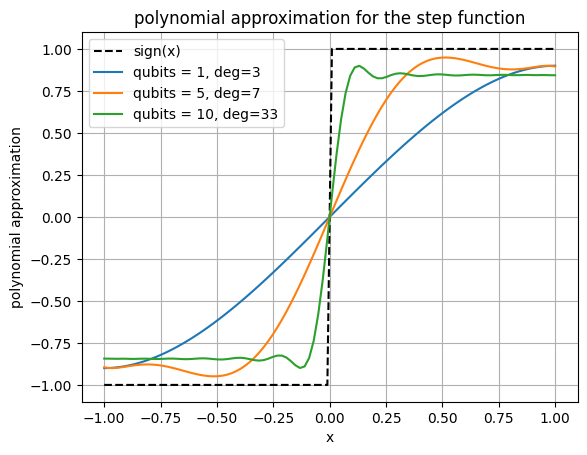

In [58]:
def sign_approximating_polynomial(num_qubits):
    """Returns the polynomial that approximates the step function theta(x) for x >= 1 / N ** 0.5"""
    N = 2 ** num_qubits
    step_function = pyqsp.poly.PolySign()

    #degree is the closest bigger odd number to N ** 0.5
    degree = np.ceil(N ** 0.5)
    if degree % 2 == 0:
        degree += 1

    #this is not the same delta as in the paper, this delta is 1 / our delta
    delta = N ** 0.5

    #finding and returning the polynomial approximation for the step function
    return step_function.generate(degree, delta=delta)

x = np.linspace(-1, 1, 100)

plt.plot(x, np.sign(x), label='sign(x)', color='black', linestyle='--')

for n in [1, 5, 10]:
    with io.capture_output() as captured:
        p = sign_approximating_polynomial(n)
    plt.plot(x, p(x), label=f'qubits = {n}, deg={p.degree()}')

plt.legend()
plt.title("polynomial approximation for the step function")
plt.xlabel("x")
plt.ylabel("polynomial approximation")
plt.legend(loc="best")
plt.grid(True)

plt.show()

To obtain a sufficiently precise approximation of the step function as the number of qubits increases, we need a polynomial of higher degree. Indeed, we can see that the higher the degree, the better the approximation becomes around $x = 0$.

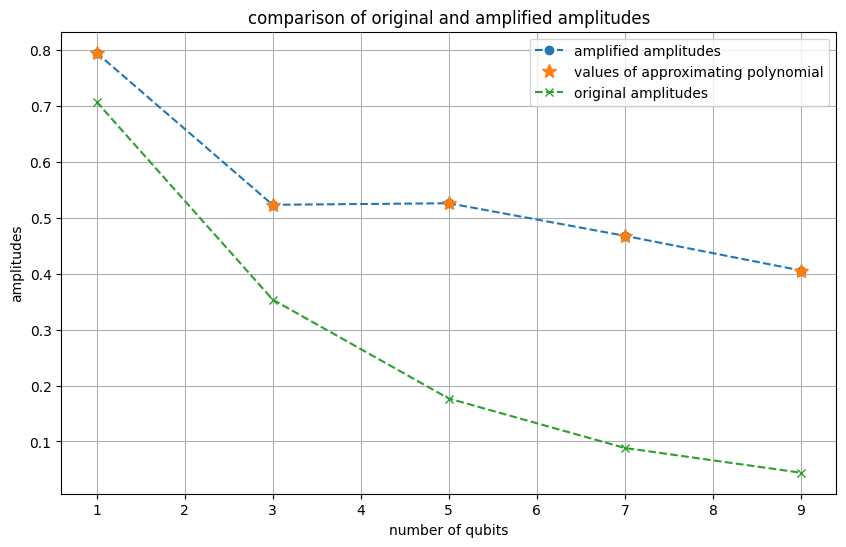

In [59]:
np.random.seed(1)

num_qubits = range(1, 11, 2)
original_amplitudes = [2 ** (-0.5 * qubits) for qubits in num_qubits]

amplitudes = []
for qubits in num_qubits:
    N = 2 ** qubits

    #inital all zero state
    all_zero_state = np.zeros(N)
    all_zero_state[0] = 1
    PR = projector_from_state(all_zero_state)

    #soltuion state m
    m = np.zeros(N)
    m[np.random.randint(0, N)] = 1
    PL = projector_from_state(m)

    #signal rotation operator U
    U = reduce(np.kron, [HADAMARD] * qubits)

    #approximating the error function and finding the corresponding QSVT angles
    with io.capture_output() as captured:
        p_sign = sign_approximating_polynomial(qubits)
        phi_vec = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p_sign.coef, signal_operator='Wx')
        phi_vec = angles_from_W_to_R(phi_vec)

    #constructing the QSVT sequence
    U_phi = QSVT(U, PL, PR, phi_vec)

    #real part of the amplified amplitude of a
    amplitude = (m @ U_phi @ all_zero_state).real

    amplitudes.append(amplitude)

with io.capture_output() as captured:
    polynomial_values = [sign_approximating_polynomial(n)(a) for n, a in zip(num_qubits, original_amplitudes)]

plt.figure(figsize=(10, 6))
plt.plot(num_qubits, amplitudes, label='amplified amplitudes', linestyle='--', marker='o')
plt.plot(num_qubits, polynomial_values, '*', label='values of approximating polynomial', markersize=10)
plt.plot(num_qubits, original_amplitudes, label='original amplitudes', linestyle='--', marker='x')

plt.xlabel('number of qubits')
plt.ylabel('amplitudes')
plt.title('comparison of original and amplified amplitudes')
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()

We can see that our original amplitudes get measurably amplified. Ideally, the amplified amplitudes would remain constant as the number of qubits increases. However, our amplified amplitudes decrease due to the error in our approximation for the polynomial.

## References

[[1] John M. Martyn, Zane M. Rossi, Andrew K. Tan, and Isaac L. Chuang, "Grand Unification of Quantum Algorithms", PRX Quantum 2, 040203, 2021](https://arxiv.org/abs/2105.02859)

[[2] Introduction to Quantum Singular Value Transformation](https://idnm.github.io/blog/posts/quantum_singular_value_transformation_intro/#sec-projector_rotations)

[[3] R. Chao, D. Ding, A. Gilyén, C. Huang, and M. Szegedy, Finding angles for quantum signal processing with machine precision (2020), ArXiv:2003.02831.](https://arxiv.org/abs/2003.02831)